<a href="https://colab.research.google.com/github/quicksilverri/fanfic-popularuty-prediction/blob/main/fanfic_popularity_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import staff

In [1]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd 
import seaborn as sns

# Get the data

In [2]:
marvel_link =  'https://archiveofourown.org/works?commit=Sort+and+Filter&work_search%5Bsort_column%5D=authors_to_sort_on&work_search%5Bother_tag_names%5D=&work_search%5Bexcluded_tag_names%5D=&work_search%5Bcrossover%5D=&work_search%5Bcomplete%5D=&work_search%5Bwords_from%5D=&work_search%5Bwords_to%5D=&work_search%5Bdate_from%5D=&work_search%5Bdate_to%5D=&work_search%5Bquery%5D=&work_search%5Blanguage_id%5D=&tag_id=Marvel'
xmen_link = 'https://archiveofourown.org/works?work_search%5Bsort_column%5D=revised_at&work_search%5Bother_tag_names%5D=&exclude_work_search%5Bfreeform_ids%5D%5B%5D=11175&exclude_work_search%5Bfreeform_ids%5D%5B%5D=263297&work_search%5Bexcluded_tag_names%5D=&work_search%5Bcrossover%5D=&work_search%5Bcomplete%5D=&work_search%5Bwords_from%5D=&work_search%5Bwords_to%5D=&work_search%5Bdate_from%5D=&work_search%5Bdate_to%5D=&work_search%5Bquery%5D=&work_search%5Blanguage_id%5D=&commit=Sort+and+Filter&tag_id=Erik+Lehnsherr*s*Charles+Xavier'
link = xmen_link
pages = 1000

### Create Fanfic class

It's kinda long and simple, so it's hidden. 

In [3]:
def clean(list): 
  """Extracts text from list of bs4.Tags"""

  return [item.get_text() for item in list]

In [4]:
class Fanfic: 
  def __init__(self, fanfic):
    self.fic = fanfic
    self.info = {}

    self.header = self.fic.select('.heading a')
    
    self.get_header()
    self.get_chapters()
    self.get_stats()
    self.get_date()
    self.get_tags()
    self.get_square()

  def get_header(self):
    """Sets title, author nickname and list of fandoms into self.stats dict"""
    
    self.info['title'] = self.header[0].get_text()
    self.info['author'] = self.header[1].get_text()
    self.info['fandoms'] = clean(self.header[2:])

  def get_chapters(self): 
    """Sets number of chapters written and number of chapters intended
    into self.stats dict"""

    def smart_int(n):
      try: 
        return int(n)
      except:
        return None

    chapters = self.fic.select('dd.chapters')[0].get_text()
    written, total = map(smart_int, chapters.split('/'))

    self.info['written'] = written
    self.info['total'] = total

  def get_number(self, selector): 
     """Processes numerical data (removes comma so it can be turned
     into integer)"""

     try: 

       data = self.fic.select(selector)[0].get_text()
       data = int(data.replace(',', ''))
       return data
        
     except: return None

  def get_stats(self): 
     """Sets data collected in Stats section (words, hits, comments,
     bookmarks, collections and language) into self.info dict"""

     self.info['words'] = self.get_number('dd.words')
     self.info['hits'] = self.get_number('dd.hits') 
     self.info['comments'] = self.get_number('dd.comments') 
     self.info['bookmarks'] = self.get_number('dd.bookmarks')
     self.info['collections'] = self.get_number('dd.collections') 
     self.info['lang'] = self.fic.select('dd.language')[0].get_text()
     self.info['kudos'] = self.get_number('.kudos a')

  def get_date(self):  # add date of first publishing??
    """Sets date of the most recent update into self.dict"""

    self.info['date'] = self.fic.select('.datetime')[0].get_text() 
    
  def get_tags(self): 
    """Sets tag-like data into self.info dict"""

    self.info['characters'] = clean(self.fic.select('.characters a.tag'))
    self.info['parings'] = clean(self.fic.select('.relationships a.tag'))
    self.info['freeforms'] = clean(self.fic.select('.freeforms a.tag'))

  def get_square(self): 
    """Sets data from square to the left of fanfic title into self.info dict"""

    self.info['rating'] = self.fic.select('.rating .text')[0].get_text()
    self.info['category'] = clean(self.fic.select('.category .text'))
    self.info['completion'] = self.fic.select('.iswip .text')[0].get_text()
    self.info['warnings'] = clean(self.fic.select('.warnings a.tag'))

  def get_info(self):
     """Return all the data about Fanfic in a DataFrame"""

     df = pd.DataFrame([self.info])

     return df

### Create FanficParser

In [5]:
class FanficParser: 
  def __init__(self, initial_link):
    self.inlink = initial_link
    self.domain = self.get_domain()
    self.df = pd.DataFrame()
    self.link = self.inlink
    self.page = 1

  def get_domain(self):
     end_of_link = self.inlink.find('/', 8)
     domain = self.inlink[:end_of_link]
     return domain
  
  def parse_page(self): 
    page = req.get(self.link)
    soup = BeautifulSoup(page.content, 'html.parser')
    fanfics = soup.select('[role~=article]')
    
    print(f'{self.page} parsed')
    self.page += 1

    new_link_relative = soup.select('li.next a')[0].get('href')
    self.link = self.domain + new_link_relative

    return fanfics

  def parse(self, n_pages): 
    for i in range(n_pages): 
      fanfics = self.parse_page()

      for fanfic in fanfics:
        self.df = self.df.append(Fanfic(fanfic).get_info())

    print(f'total {self.df.shape[0]} fanfics')

    self.df.index = range(self.df.shape[0])

  def reset(self):
    self.df = pd.DataFrame()
    self.link = self.inlink
    self.page = 1
    print('Parser resetted')

## Parse info

In [6]:
parser = FanficParser(link)
parser.parse(pages)

1 parsed
2 parsed
3 parsed
4 parsed
5 parsed
6 parsed
7 parsed
8 parsed
9 parsed
10 parsed
11 parsed
12 parsed
13 parsed
14 parsed
15 parsed
16 parsed
17 parsed
18 parsed
19 parsed
20 parsed
21 parsed
22 parsed
23 parsed
24 parsed
25 parsed
26 parsed
27 parsed
28 parsed
29 parsed
30 parsed
31 parsed
32 parsed
33 parsed
34 parsed
35 parsed
36 parsed
37 parsed
38 parsed
39 parsed
40 parsed
41 parsed
42 parsed
43 parsed
44 parsed
45 parsed
46 parsed
47 parsed
48 parsed
49 parsed
50 parsed
51 parsed
52 parsed
53 parsed
54 parsed
55 parsed
56 parsed
57 parsed
58 parsed
59 parsed
60 parsed
61 parsed
62 parsed
63 parsed
64 parsed
65 parsed
66 parsed
67 parsed
68 parsed
69 parsed
70 parsed
71 parsed
72 parsed
73 parsed
74 parsed
75 parsed
76 parsed
77 parsed
78 parsed
79 parsed
80 parsed
81 parsed
82 parsed
83 parsed
84 parsed
85 parsed
86 parsed
87 parsed
88 parsed
89 parsed
90 parsed
91 parsed
92 parsed
93 parsed
94 parsed
95 parsed
96 parsed
97 parsed
98 parsed
99 parsed
100 parsed
total 20

In [42]:
parser.parse(pages)

357 parsed


IndexError: ignored

In [44]:
df = parser.df

In [45]:
df.shape

(7063, 20)

# Data preprocessing 
So now we have to figure out what type of data can be suitable for our model. 

1. Replace missing values 
2. Parse dates 
3. Replace categorical values with numbers

In [46]:
df['comments'] = df['comments'].fillna(0)
df['bookmarks'] = df['bookmarks'].fillna(0)
df['collections'] = df['collections'].fillna(0)
df['kudos'] = df['kudos'].fillna(0)

In [49]:
ratings = {
    'Not Rated': -1,
    'General Audiences': 0, 
    'Teen And Up Audiences': 1, 
    'Mature': 2, 
    'Explicit': 3, 
}
replace_rating = lambda x: ratings[x] if x not in [-1, 0, 1, 2, 3] else x
df['rating'] = df['rating'].apply(replace_rating)

In [51]:
completion = {'Work in Progress': 0, 'Complete Work': 1}
replace_completion = lambda x: completion[x] if x not in [0, 1] else x
df['completion'] = df['completion'].apply(replace_completion)

In [52]:
df['date'] = df['date'].apply(pd.to_datetime)

# IDK staff

## Let's look at the data

In [13]:
fandom_list = set()

for fandoms in df.fandoms:
  for fandom in fandoms: 
    fandom_list.add(fandom)

In [14]:
fandom_count = {}

for fandoms in df.fandoms:
  for fandom in fandoms: 
    try: 
      fandom_count[fandom] += 1
    except: 
      fandom_count[fandom] = 1

In [15]:
count = pd.Series(fandom_count)

In [16]:
count = count.sort_values(ascending=False)

In [17]:
df_count = pd.DataFrame()
df_count['count'] = count
df_count['fandom'] = count.index

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

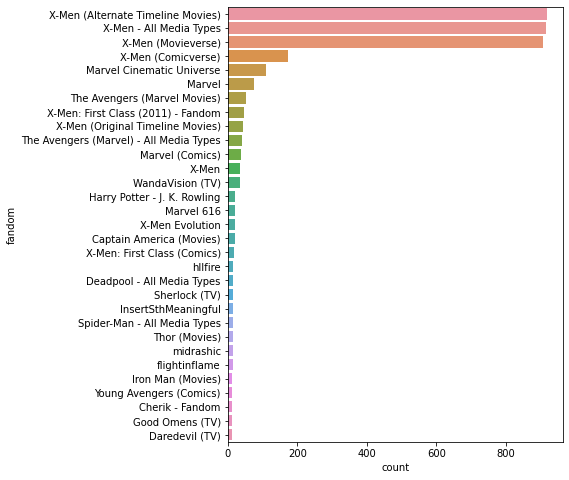

In [19]:
plt.figure(figsize=(6, 8))
sns.barplot(data=df_count[df_count['count'] > 10], x='count', y='fandom', orient='h')

In [20]:
len(fandom_list)

558

In [21]:
df.fandoms[0]

['X-Men - All Media Types', 'X-Men (Movieverse)']

In [22]:
df.sample()

,title,author,fandoms,written,total,words,hits,comments,bookmarks,collections,lang,kudos,date,characters,parings,freeforms,rating,category,completion,warnings
1296,Beso en la prision.,Eli_ana10,[X-Men (Movieverse)],1,1,441,635,0,3,0,Español,62,2021-02-19,"[Pietro Maximoff, Logan (X-Men), Erik Lehnsher...","[Erik Lehnsherr/Charles Xavier, Logan (X-Men)/...","[Escape, beso]",0,[M/M],1,[Creator Chose Not To Use Archive Warnings]


## Let's look at the correlation

In [ ]:
df_num = df[['written', 'words', 'hits', 'comments', 'bookmarks', 'collections', 'rating', 'kudos', 'completion']]
df_num['words_per_chapter'] = df_num['words'] / df_num['written']
df_num['lang_num'] = df['lang'].apply(lambda x: 1 if x == 'English' else 0)
df_num['kudos_per_hit'] = df['kudos'] / df['hits']

In [54]:
df_num.describe()

,written,hits,comments,bookmarks,collections,rating,kudos,completion,lang_num,kudos_per_hit
count,7063.000000,7.063000e+03,7063.000000,7063.000000,7063.000000,7063.000000,7063.000000,7063.000000,7063.000000,7063.000000
mean,3.427156,2.807494e+03,17.637548,15.372080,0.163103,1.099108,122.628911,0.817216,0.728302,0.062411
std,7.843884,2.396924e+04,60.610381,47.048789,0.441751,1.240348,257.583866,0.386516,0.444866,0.040729
min,1.000000,5.000000e+00,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.590000e+02,1.000000,1.000000,0.000000,0.000000,20.000000,1.000000,0.000000,0.034332
50%,1.000000,9.900000e+02,5.000000,4.000000,0.000000,1.000000,55.000000,1.000000,1.000000,0.056738
75%,2.000000,2.203500e+03,14.000000,13.000000,0.000000,2.000000,130.000000,1.000000,1.000000,0.083333
max,206.000000,1.535007e+06,2389.000000,2065.000000,16.000000,3.000000,7730.000000,1.000000,1.000000,1.285714


In [56]:
best_ff = df[df_num.kudos_per_hit >= 0.2]

In [57]:
df_corr = df_num.corr()

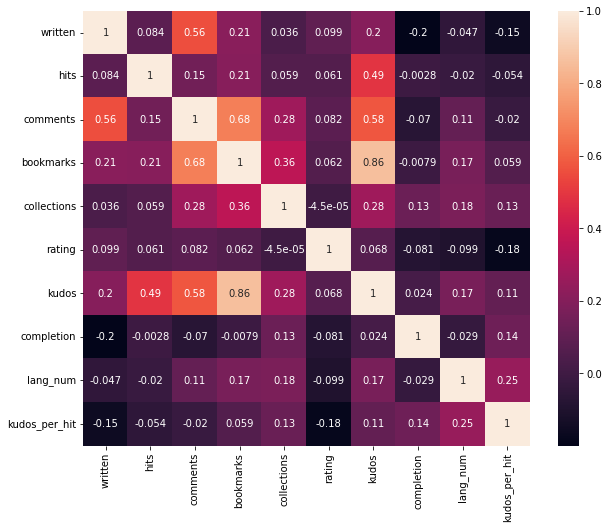

In [58]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True)

In [65]:
df_num[df.hits == df.hits.max()]

,written,words,hits,comments,bookmarks,collections,rating,kudos,completion,words_per_chapter,lang_num,kudos_per_hit
0,14,44417,1535007,20,83,0,3,4423,1,3172.642857,0,0.002881


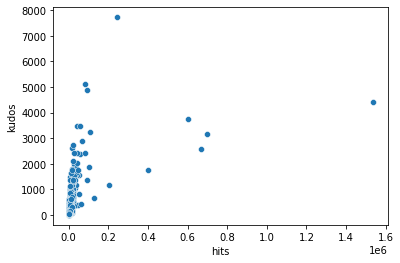

In [59]:
sns.scatterplot(x=df.hits, y=df.kudos)

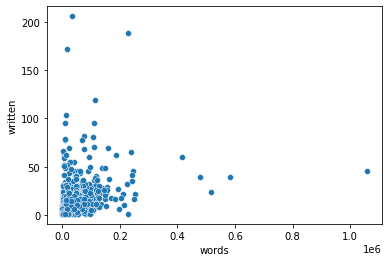

In [61]:
sns.scatterplot(x=df.words, y=df.written)

# Machine Learning yo

In [37]:
import sklearn 

In [31]:
houses_df = pd.read_csv('sample_data/california_housing_train.csv')

In [32]:
houses_corr = houses_df.corr()

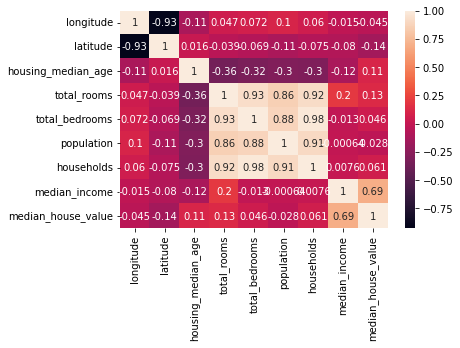

In [33]:
sns.heatmap(houses_corr, annot=True)

In [35]:
houses_df.shape

(17000, 9)

In [36]:
df_test = pd.read_csv('sample_data/california_housing_test.csv')
df_test.shape

(3000, 9)